# COMP5318 assignment 2: Classification

### Group number: Assignment 2 220, SID1: 520026168 , SID2: 520638064 , SID3: 510423153

## Setup and Dependencies

In [2]:
! pip install scikeras
! pip install seaborn
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

## 1. Data Loading

In [3]:
#File integrity verification and visualization

# Load the training and testing data
train_file = 'EMNIST_Byclass_Small/emnist_train.pkl'
test_file = 'EMNIST_Byclass_Small/emnist_test.pkl'

with open(train_file, 'rb') as f:
    train_data = pickle.load(f, encoding='bytes')

with open(test_file, 'rb') as f:
    test_data = pickle.load(f, encoding='bytes')

# Print the keys of the dictionaries
print(train_data.keys())
print(test_data.keys())

dict_keys(['data', 'labels'])
dict_keys(['data', 'labels'])


X_train shape: (100000, 784)
X_train_img shape: (100000, 28, 28)
X_test shape: (20000, 784)
X_test_img shape: (20000, 28, 28)
y_train shape: (100000,)
y_test shape: (20000,)


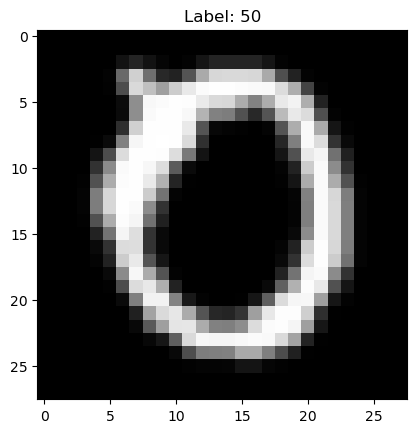

In [4]:
# Extract the data and labels from the dictionaries
X_train_img, y_train = train_data['data'], train_data['labels']
X_test_img, y_test = test_data['data'], test_data['labels']

# Flatten the images and convert the pixel values to floats
X_train = X_train_img.reshape(X_train_img.shape[0], -1).astype(np.float32)
X_test = X_test_img.reshape(X_test_img.shape[0], -1).astype(np.float32)
X_train_img = X_train_img.astype(np.float32)
X_test_img = X_test_img.astype(np.float32)

# Print the shapes of the data and labels
print('X_train shape:', X_train.shape)
print('X_train_img shape:', X_train_img.shape)
print('X_test shape:', X_test.shape)
print('X_test_img shape:', X_test_img.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

# Visualize a sample image from the dataset
plt.imshow(X_train_img[0], cmap='gray')
plt.title('Label: ' + str(y_train[0]))
plt.show()

## 2. Data Preprocessing

This section includes the data visualization of the label distributions.

As well as principal component analysis and Normalization.

### 2.1 Data Visualization and Descriptive Analysis

Plot the distribution of labels and display some sample images.

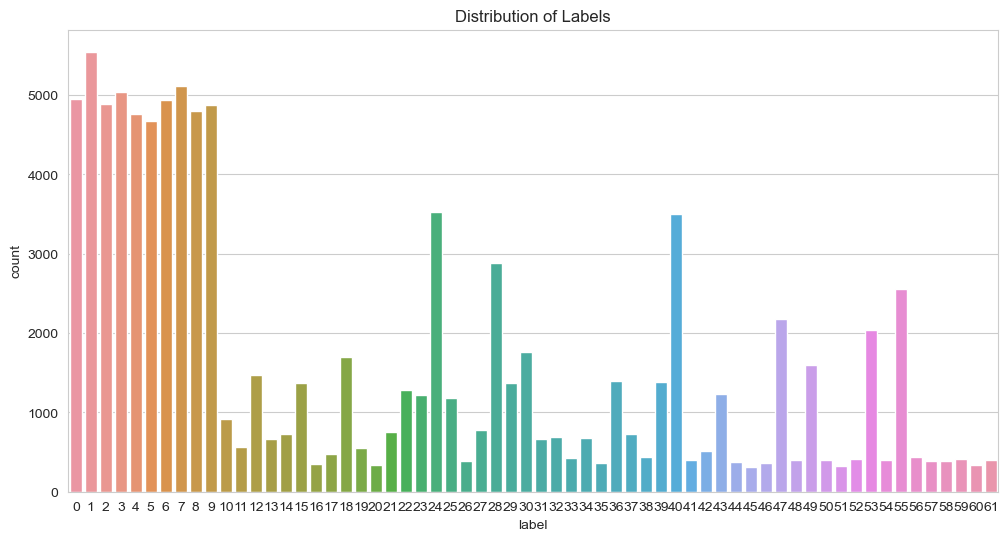

In [5]:
# Create a DataFrame to store the labels and their counts
labels_df = pd.DataFrame({'label': y_train})
labels_df['count'] = 1

# Plot the distribution of labels
sns.set_style(style='whitegrid')
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=labels_df)
plt.title('Distribution of Labels')
plt.show()

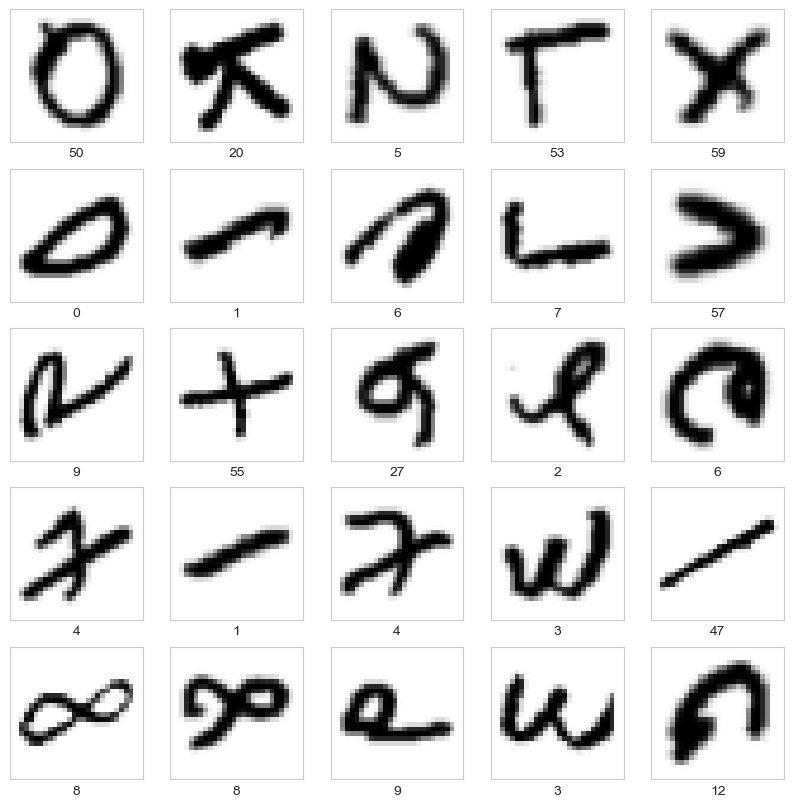

Mean of pixel values: 44.1997
Standard deviation of pixel values: 84.52435


In [6]:
# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_img[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

# Calculate the mean and standard deviation of the pixel values
pixel_mean = np.mean(X_train_img)
pixel_std = np.std(X_train_img)
print('Mean of pixel values:', pixel_mean)
print('Standard deviation of pixel values:', pixel_std)

### 2.2 One-hot Coding

In [7]:
# Change the label to the one-hot mode
y_train_one = tf.keras.utils.to_categorical(y_train, 62)
y_test_one = tf.keras.utils.to_categorical(y_test, 62)

print('y_train_one shape:', y_train_one.shape)
print('y_test_one shape:', y_test_one.shape)

y_train_one shape: (100000, 62)
y_test_one shape: (20000, 62)


### 2.3 Normalization

In [8]:
# Normalize the pixel values to be between 0 and 1
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0
X_train_img_norm = X_train_img / 255.0
X_test_img_norm = X_test_img / 255.0

# Print the shapes of the preprocessed data
print('X_train_norm shape:', X_train_norm.shape)
print('X_test_norm shape:', X_test_norm.shape)
print('X_train_img_norm shape:', X_train_img_norm.shape)
print('X_test_img_norm shape:', X_test_img_norm.shape)

X_train_norm shape: (100000, 784)
X_test_norm shape: (20000, 784)
X_train_img_norm shape: (100000, 28, 28)
X_test_img_norm shape: (20000, 28, 28)


### 2.4 PCA

Select the best PCA components.

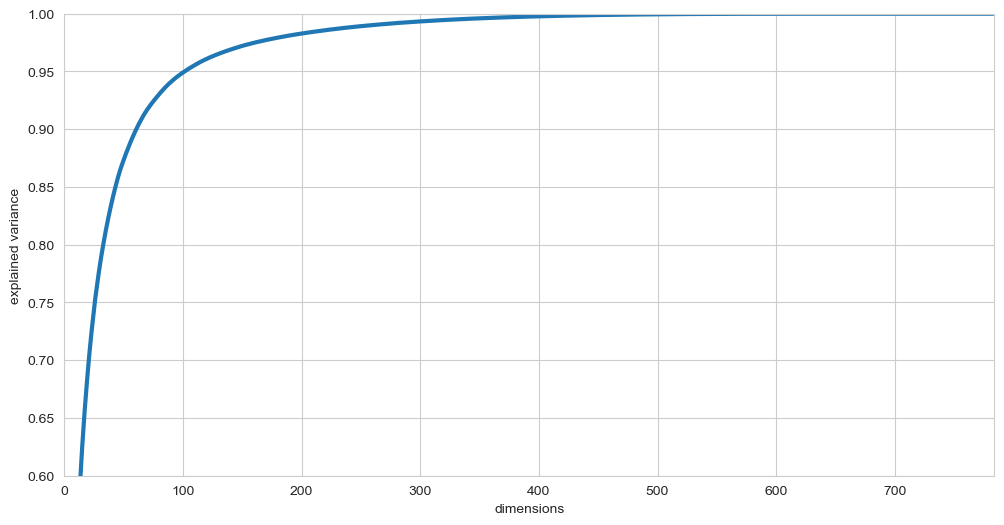

In [9]:
# Perform PCA without reducing dimensionality pca = PCA()
pca = PCA()
pca.fit(X_train_norm)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions
plt.figure(figsize=(12, 6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 784, 0.6, 1])
plt.xlabel("dimensions")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

Select 0.95 as the components and apply.

In [10]:
# Apply PCA to reduce the dimensionality of the data
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

# Print the shapes of the preprocessed data
print('X_train_pca shape:', X_train_pca.shape)
print('X_test_pca shape:', X_test_pca.shape)

X_train_pca shape: (100000, 103)
X_test_pca shape: (20000, 103)


## 3. Three Models

### 3.1 K-Nearest Neighbour

Calculate the metrics.

In [11]:
# KNN classifier and train
knn = KNeighborsClassifier(n_neighbors=1, weights='distance')
knn.fit(X=X_train_pca, y=y_train)

# Predict the test data
accuracy_knn = knn.score(X=X_test_pca, y=y_test)
pred_knn = knn.predict(X=X_test_pca)

# Calculate and print the metrics
precision_knn = precision_score(y_true=y_test, y_pred=pred_knn, average='macro')
recall_knn = recall_score(y_true=y_test, y_pred=pred_knn, average='macro')
cm_knn = confusion_matrix(y_true=y_test, y_pred=pred_knn)

print("Accuracy on test set: {:.3f}%".format(100 * accuracy_knn))
print("Precision on test set: {:.3f}%".format(100 * precision_knn))
print("Recall on test set: {:.3f}%".format(100 * recall_knn))
print("Confusion_matrix: \n", cm_knn)

Accuracy on test set: 66.960%
Precision on test set: 55.571%
Recall on test set: 49.024%
Confusion_matrix: 
 [[564   2   0 ...   0   0   0]
 [  0 683   2 ...   0   0   0]
 [ 21  12 802 ...   0   1  29]
 ...
 [  0   7   3 ...  45   4   0]
 [  0   6   0 ...   1  11   0]
 [  0   1  28 ...   0   0  24]]


Classification report.

In [12]:
# Classification report
print(classification_report(y_true=y_test, y_pred=pred_knn))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       976
           1       0.48      0.67      0.56      1023
           2       0.88      0.80      0.84      1003
           3       0.87      0.90      0.88      1035
           4       0.87      0.77      0.82       903
           5       0.78      0.71      0.74       928
           6       0.89      0.92      0.90       959
           7       0.86      0.93      0.89      1098
           8       0.97      0.76      0.85       941
           9       0.84      0.86      0.85       929
          10       0.70      0.43      0.53       170
          11       0.57      0.10      0.17       118
          12       0.53      0.65      0.58       316
          13       0.73      0.35      0.47       128
          14       0.89      0.43      0.58       162
          15       0.64      0.47      0.54       261
          16       0.71      0.37      0.48        60
          17       0.51    

Visualize the confusion matrix.

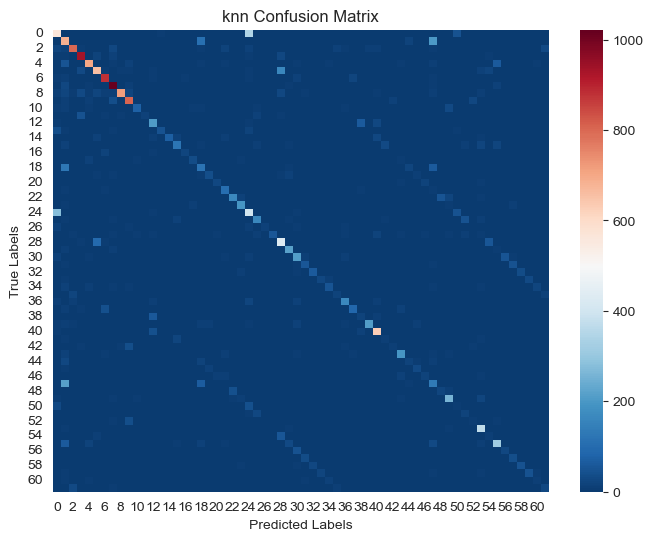

In [13]:
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(data=cm_knn, fmt="d", cmap="RdBu_r", center=500)
plt.title("knn Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### 3.2 Fully Connected Neural Network

In [13]:
# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)

MLP model

In [14]:
# Define MLP model by layer
model_NN = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train_norm.shape[1]]),
    keras.layers.Dense(units=500, activation='tanh'),  # relu
    keras.layers.Dense(units=300, activation='tanh'),  # relu
    keras.layers.Dense(units=62, activation='softmax')  # output layer
])

model_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 62)                18662     
                                                                 
Total params: 561,462
Trainable params: 561,462
Non-trainable params: 0
_________________________________________________________________


Compile and train.

In [15]:
# Instantiate optimizer and compile the model
model_NN.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                 metrics=['accuracy', 'Precision', 'Recall'])

# Train the classifier
model_NN_results = model_NN.fit(x=X_train_norm, y=y_train_one, epochs=10, batch_size=64, shuffle=True,
                                validation_split=0.2)

Epoch 1/10
   1/1250 [..............................] - ETA: 3:36 - loss: 4.1997 - accuracy: 0.0156 - precision: 0.0000e+00 - recall: 0.0000e+00

2023-05-15 00:59:20.494638: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1250/1250 [==============================] - 3s 3ms/step - loss: 1.0125 - accuracy: 0.7066 - precision: 0.8200 - recall: 0.6066 - val_loss: 0.7635 - val_accuracy: 0.7627 - val_precision: 0.8385 - val_recall: 0.6880
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.6703 - accuracy: 0.7846 - precision: 0.8430 - recall: 0.7265 - val_loss: 0.6466 - val_accuracy: 0.7971 - val_precision: 0.8464 - val_recall: 0.7503
Epoch 3/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5690 - accuracy: 0.8090 - precision: 0.8546 - recall: 0.7644 - val_loss: 0.5951 - val_accuracy: 0.8098 - val_precision: 0.8568 - val_recall: 0.7664
Epoch 4/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5099 - accuracy: 0.8250 - precision: 0.8628 - recall: 0.7861 - val_loss: 0.5792 - val_accuracy: 0.8085 - val_precision: 0.8500 - val_recall: 0.7732
Epoch 5/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4639 - accuracy: 0.8363 - pre

Visualize the training results.

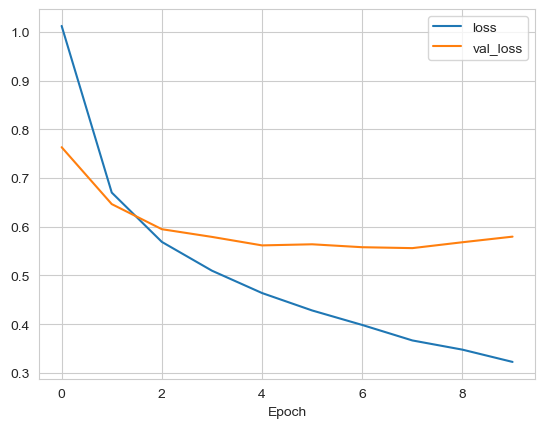

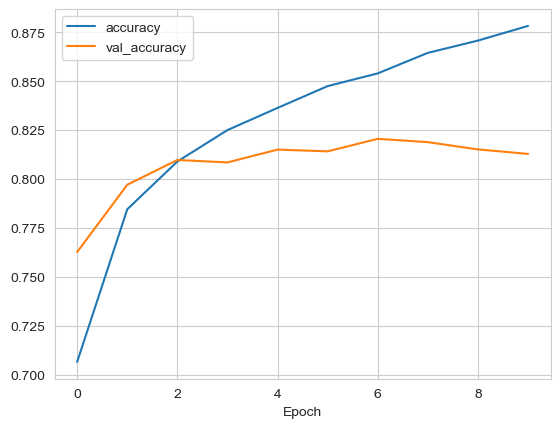

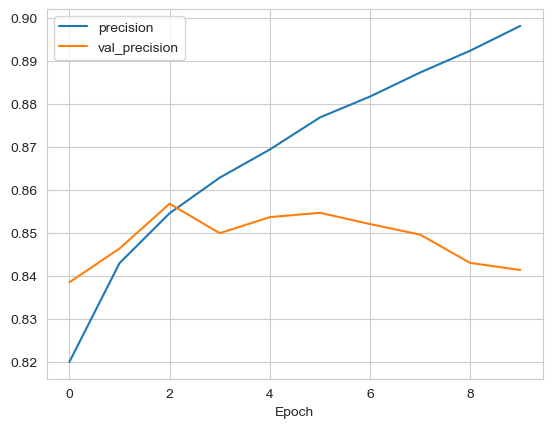

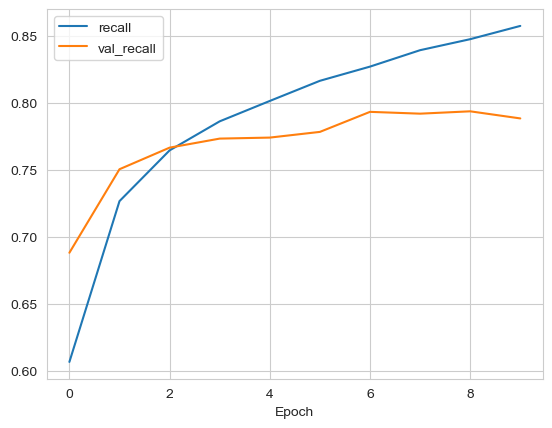

In [16]:
# Convert the history result dictionary to a Pandas dataframe and extract the accuracies
loss_NN = pd.DataFrame(model_NN_results.history)[['loss', 'val_loss']]
accuracy_NN = pd.DataFrame(model_NN_results.history)[['accuracy', 'val_accuracy']]
precision_NN = pd.DataFrame(model_NN_results.history)[['precision', 'val_precision']]
recall_NN = pd.DataFrame(model_NN_results.history)[['recall', 'val_recall']]

# Plot
loss_NN.plot()
plt.xlabel('Epoch')
plt.show()

accuracy_NN.plot()
plt.xlabel('Epoch')
plt.show()

precision_NN.plot()
plt.xlabel('Epoch')
plt.show()

recall_NN.plot()
plt.xlabel('Epoch')
plt.show()

Calculate the metrics on test set.

In [17]:
# Evaluate the test data
loss_NN_test, accuracy_NN_test, precision_NN_test, recall_NN_test = model_NN.evaluate(x=X_test_norm, y=y_test_one)

pred_NN = model_NN.predict(x=X_test_norm)
cm_NN = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred_NN, axis=1))

print("Loss on test set: {:.4f}".format(loss_NN_test))
print("Accuracy on test set: {:.4f}%".format(100 * accuracy_NN_test))
print("Precision on test set: {:.4f}%".format(100 * precision_NN_test))
print("Recall on test set: {:.4f}%".format(100 * recall_NN_test))
print("Confusion_matrix: \n", cm_NN)

625/625 [==============================] - 0s 652us/step
Loss on test set: 0.5870
Accuracy on test set: 80.6650%
Precision on test set: 83.1636%
Recall on test set: 78.3900%
Confusion_matrix: 
 [[854   0   1 ...   0   0   0]
 [  0 912   3 ...   0   0   0]
 [  1   0 962 ...   1   0   4]
 ...
 [  0   1   2 ...  65   0   0]
 [  0   1   0 ...   0   8   0]
 [  0   0  40 ...   0   0  23]]


Classification report

In [18]:
print(classification_report(y_true=y_test, y_pred=np.argmax(pred_NN, axis=1)))

              precision    recall  f1-score   support

           0       0.61      0.88      0.72       976
           1       0.67      0.89      0.76      1023
           2       0.89      0.96      0.92      1003
           3       0.96      0.97      0.97      1035
           4       0.92      0.95      0.93       903
           5       0.86      0.92      0.89       928
           6       0.94      0.95      0.95       959
           7       0.97      0.97      0.97      1098
           8       0.93      0.95      0.94       941
           9       0.91      0.96      0.93       929
          10       0.84      0.87      0.85       170
          11       0.85      0.73      0.79       118
          12       0.72      0.65      0.68       316
          13       0.75      0.77      0.76       128
          14       0.91      0.85      0.88       162
          15       0.81      0.75      0.78       261
          16       0.71      0.70      0.71        60
          17       0.72    

Visualize the confusion matrix.

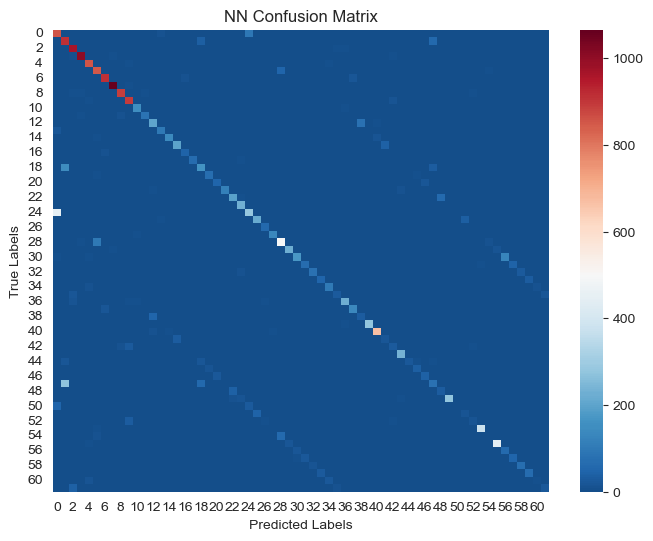

In [19]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=cm_NN, fmt="d", cmap="RdBu_r", center=500)
plt.title("NN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### 3.3 ResNet-18

ResNet-18 model

In [20]:
# The residual block
def residual_block(inputs, out_channel, activation_fn, same_shape=False):
    """
    The residual block in ResNet-18.

    :param inputs: input tensor to the residual block
    :param out_channel: number of output channels/filters for the convolutional layers in the block
    :param activation_fn: activation function to be applied after each convolutional layer
    :param same_shape: a boolean flag indicating whether the input and output tensors should have the same shape
                       If False, the input tensor will be downsampled by a factor of 2
    :return: output tensor of the residual block
    """
    strides = (2, 2) if same_shape else (1, 1)

    # Convolution layers
    x = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(3, 3), strides=strides, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=activation_fn)(x)
    x = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Downsample the input if needed
    if same_shape:
        inputs = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(1, 1), strides=(2, 2), padding="same")(inputs)

    # Add the residual connection
    x = tf.keras.layers.Add()([x, inputs])
    x = tf.keras.layers.Activation(activation=activation_fn)(x)

    return x


# ResNet 18
def ResNet(activation_fn):
    """
    ResNet-18 Model.

    :param activation_fn: activation function to be applied after each convolutional layer
    :return: ResNet-18 model
    """
    inputs = tf.keras.Input(shape=(28, 28, 1))

    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=activation_fn)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

    # Residual blocks
    x = residual_block(inputs=x, out_channel=64, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=64, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=128, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=128, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=256, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=256, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=512, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=512, activation_fn=activation_fn)

    # Global average pooling and dense layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=62, activation="softmax")(x)

    # Create and return the ResNet-18 model
    res_net = tf.keras.Model(inputs=inputs, outputs=x)

    return res_net


# Initialize
model_CNN = ResNet(activation_fn='relu')

In [21]:
model_CNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   3200        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 14, 14, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 14, 14, 64)   0           ['batch_normalization[0][0]']

                                                                                                  
 conv2d_10 (Conv2D)             (None, 2, 2, 256)    295168      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 2, 2, 256)   1024        ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 2, 2, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 2, 2, 256)    590080      ['activation_9[0][0]']           
                                                                                                  
 batch_nor

Compile and train.

In [22]:
# Instantiate optimizer and compile the model
model_CNN.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="categorical_crossentropy",
                  metrics=['accuracy', 'Precision', 'Recall'])
model_CNN_results = model_CNN.fit(x=X_train_img_norm, y=y_train_one, batch_size=64, epochs=10, validation_split=0.2,
                                  shuffle=True)

Epoch 1/10
1250/1250 [==============================] - 300s 240ms/step - loss: 0.7361 - accuracy: 0.7639 - precision: 0.8168 - recall: 0.7157 - val_loss: 0.6104 - val_accuracy: 0.7871 - val_precision: 0.8283 - val_recall: 0.7473
Epoch 2/10
1250/1250 [==============================] - 301s 241ms/step - loss: 0.4993 - accuracy: 0.8237 - precision: 0.8534 - recall: 0.7921 - val_loss: 0.5388 - val_accuracy: 0.8170 - val_precision: 0.8531 - val_recall: 0.7840
Epoch 3/10
1250/1250 [==============================] - 300s 240ms/step - loss: 0.4544 - accuracy: 0.8365 - precision: 0.8633 - recall: 0.8090 - val_loss: 0.4906 - val_accuracy: 0.8366 - val_precision: 0.8598 - val_recall: 0.8135
Epoch 4/10
1250/1250 [==============================] - 299s 240ms/step - loss: 0.4224 - accuracy: 0.8456 - precision: 0.8703 - recall: 0.8211 - val_loss: 0.4823 - val_accuracy: 0.8328 - val_precision: 0.8602 - val_recall: 0.8055
Epoch 5/10
1250/1250 [==============================] - 298s 238ms/step - loss: 

Visualize the training results.

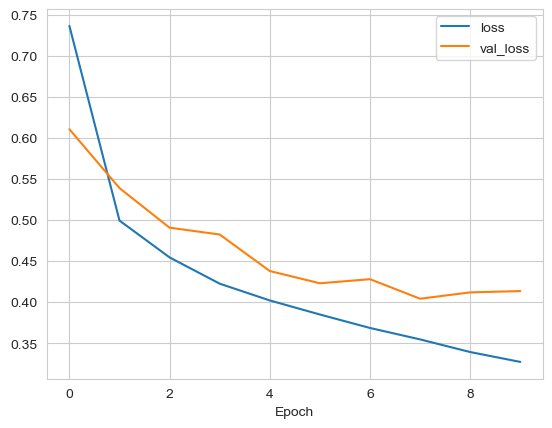

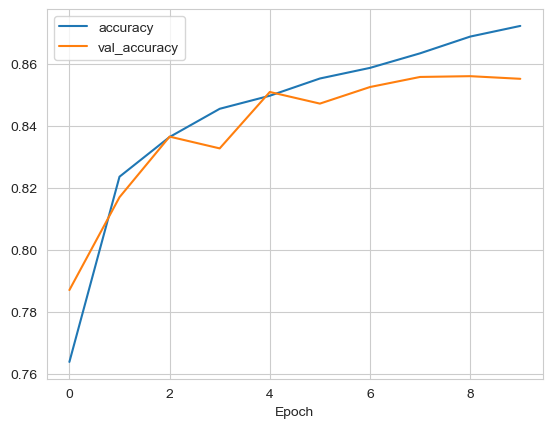

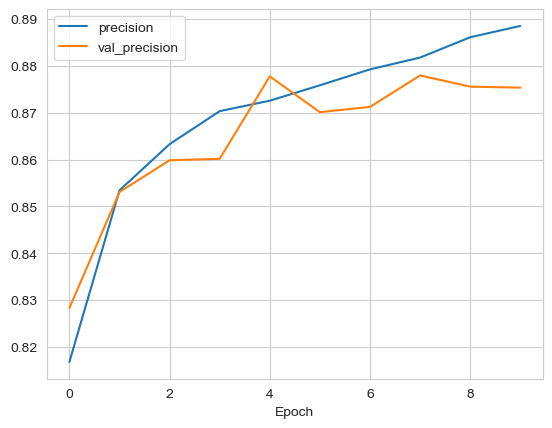

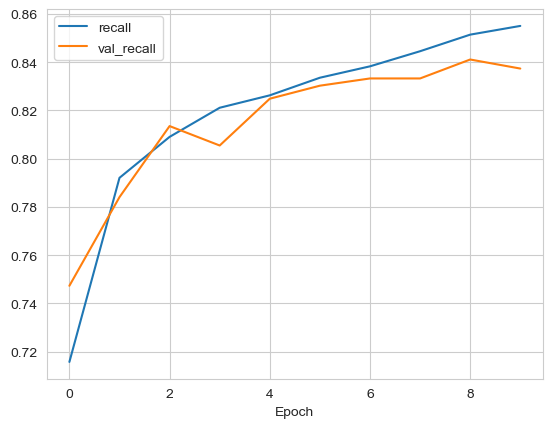

In [23]:
# Convert the history result dictionary to a Pandas dataframe and extract the accuracies
loss_CNN = pd.DataFrame(model_CNN_results.history)[['loss', 'val_loss']]
accuracy_CNN = pd.DataFrame(model_CNN_results.history)[['accuracy', 'val_accuracy']]
precision_CNN = pd.DataFrame(model_CNN_results.history)[['precision', 'val_precision']]
recall_CNN = pd.DataFrame(model_CNN_results.history)[['recall', 'val_recall']]

# Plot
loss_CNN.plot()
plt.xlabel('Epoch')
plt.show()

accuracy_CNN.plot()
plt.xlabel('Epoch')
plt.show()

precision_CNN.plot()
plt.xlabel('Epoch')
plt.show()

recall_CNN.plot()
plt.xlabel('Epoch')
plt.show()

Calculate metrics on test set.

In [24]:
# Evaluate the test data
loss_CNN_test, accuracy_CNN_test, precision_CNN_test, recall_CNN_test = model_CNN.evaluate(x=X_test_img_norm,
                                                                                           y=y_test_one)

pred_CNN = model_CNN.predict(x=X_test_img_norm)
cm_CNN = confusion_matrix(y_true=y_test, y_pred=np.argmax(pred_CNN, axis=1))

print("Loss on test set: {:.4f}".format(loss_CNN_test))
print("Accuracy on test set: {:.4f}%".format(100 * accuracy_CNN_test))
print("Precision on test set: {:.4f}%".format(100 * precision_CNN_test))
print("Recall on test set: {:.4f}%".format(100 * recall_CNN_test))
print("Confusion_matrix: \n", cm_CNN)

625/625 [==============================] - 10s 16ms/step
Loss on test set: 0.4238
Accuracy on test set: 85.0800%
Precision on test set: 87.0469%
Recall on test set: 83.0950%
Confusion_matrix: 
 [[827   0   1 ...   0   0   0]
 [  0 964   1 ...   0   0   0]
 [  0   0 983 ...   1   0   4]
 ...
 [  0   0   0 ...  87   1   0]
 [  0   0   0 ...   0  15   0]
 [  0   0  16 ...   2   0  46]]


Classification report

In [27]:
print(classification_report(y_true=y_test, y_pred=np.argmax(pred_CNN, axis=1)))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       976
           1       0.66      0.94      0.78      1023
           2       0.95      0.98      0.96      1003
           3       1.00      0.99      0.99      1035
           4       0.97      0.95      0.96       903
           5       0.90      0.95      0.92       928
           6       0.96      0.97      0.97       959
           7       0.95      0.99      0.97      1098
           8       0.97      0.96      0.97       941
           9       0.92      0.97      0.94       929
          10       0.95      0.95      0.95       170
          11       0.92      0.86      0.89       118
          12       0.70      0.98      0.82       316
          13       0.93      0.88      0.90       128
          14       0.97      0.93      0.95       162
          15       0.82      0.93      0.87       261
          16       0.89      0.85      0.87        60
          17       0.85    

Visualize the confusion matrix.

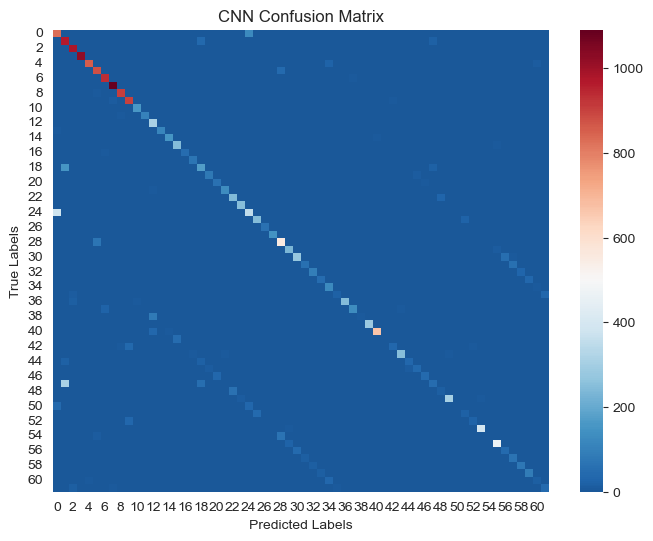

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=cm_CNN, fmt="d", cmap="RdBu_r", center=500)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 4. Hyperparameter Tuning

### 4.1 Hyperparameter Tuning for KNN

Grid search for KNN hyperparameter tuning.

In [31]:
# grid-search with cross-validation for parameter tuning
param_grid_knn = {'n_neighbors': [1, 3, 5], 'weights': ['uniform', 'distance']}

grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, cv=2,
                               return_train_score=True, scoring=['accuracy', 'precision_macro', 'recall_macro'],
                               refit='accuracy')
grid_search_knn.fit(X=X_train_pca, y=y_train)

print("Best parameters: {}".format(grid_search_knn.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_knn.best_score_))
print("Best estimator: {}".format(grid_search_knn.best_estimator_))
print("Test set score: {:.4f}".format(grid_search_knn.score(X_test_pca, y_test)))

Best parameters: {'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.66
Best estimator: KNeighborsClassifier(weights='distance')
Test set score: 0.6958


Visualize the performance of different Hyperparameters.

In [32]:
cv_results_knn = grid_search_knn.cv_results_

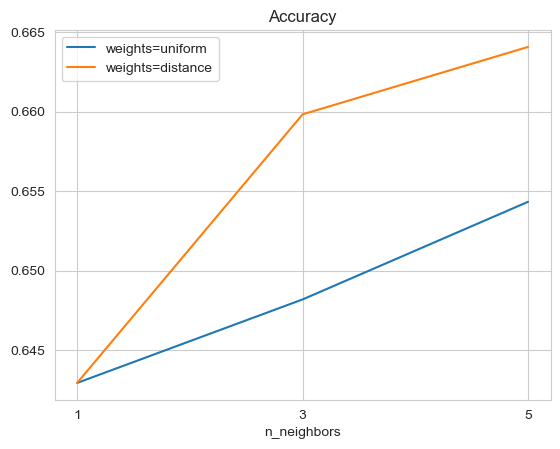

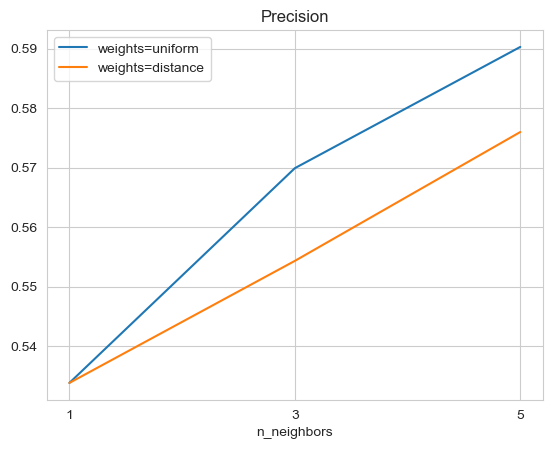

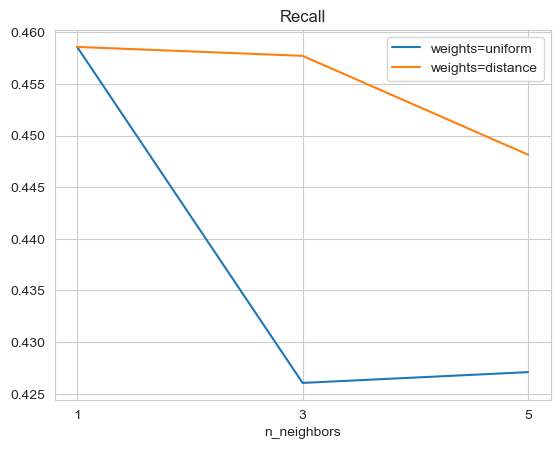

In [33]:
grid_accuracy_knn = []
grid_precision_knn = []
grid_recall_knn = []

# Append the metrics to the lists from the cv_results
for i in range(len(param_grid_knn['weights'])):
    temp1 = []
    temp2 = []
    temp3 = []
    for j in range(len(cv_results_knn['params'])):
        if param_grid_knn['weights'][i] == cv_results_knn['params'][j]['weights']:
            temp1.append(cv_results_knn['mean_test_accuracy'][j])
            temp2.append(cv_results_knn['mean_test_precision_macro'][j])
            temp3.append(cv_results_knn['mean_test_recall_macro'][j])
    grid_accuracy_knn.append(temp1)
    grid_precision_knn.append(temp2)
    grid_recall_knn.append(temp3)

# Plot
for i in range(len(param_grid_knn['weights'])):
    plt.plot(range(len(param_grid_knn['n_neighbors'])), grid_accuracy_knn[i],
             label=("weights={}".format(param_grid_knn['weights'][i])))
plt.legend()
plt.title("Accuracy")
plt.xticks(range(len(param_grid_knn['n_neighbors'])), param_grid_knn['n_neighbors'])
plt.xlabel("n_neighbors")
plt.show()

for i in range(len(param_grid_knn['weights'])):
    plt.plot(range(len(param_grid_knn['n_neighbors'])), grid_precision_knn[i],
             label=("weights={}".format(param_grid_knn['weights'][i])))
plt.legend()
plt.title("Precision")
plt.xticks(range(len(param_grid_knn['n_neighbors'])), param_grid_knn['n_neighbors'])
plt.xlabel("n_neighbors")
plt.show()

for i in range(len(param_grid_knn['weights'])):
    plt.plot(range(len(param_grid_knn['n_neighbors'])), grid_recall_knn[i],
             label=("weights={}".format(param_grid_knn['weights'][i])))
plt.legend()
plt.title("Recall")
plt.xticks(range(len(param_grid_knn['n_neighbors'])), param_grid_knn['n_neighbors'])
plt.xlabel("n_neighbors")
plt.show()

### 4.2 Hyperparameter Tuning for MLP

Grid search for MLP hyperparameter tuning.

In [34]:
# Hyperparameter tuning initialisation
# define a function which allows us to quickly build a Keras model with our desired parameters
def build_mlp(n_hidden_layers=2, n_hidden_neurons=50, activation_function="relu", input_shape=[X_train_norm.shape[1]]):
    """
    Build a Keras MLP for 62 class classification with desired parameters.

    :param n_hidden_layers: number of hidden layers in the MLP
    :param n_hidden_neurons: number of neurons in each hidden layer
    :param activation_function: activation function to be used in the hidden layers
    :param input_shape: shape of the input data
    :return: constructed MLP model
    """
    # Model initialisation
    model = keras.models.Sequential()

    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))

    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(units=n_hidden_neurons, activation=activation_function))

    # Add the output layer for 100 class classification
    model.add(keras.layers.Dense(units=62, activation="softmax"))

    return model


# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier_NN = KerasClassifier(model=build_mlp, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                                      loss="categorical_crossentropy", batch_size=64,
                                      metrics=['accuracy', 'Precision', 'Recall'], epochs=10, shuffle=True,
                                      validation_split=0.2, n_hidden_neurons=50, activation_function="relu", )

In [35]:
# grid-search with cross-validation for parameter tuning
param_grid_NN = {"n_hidden_neurons": [100, 300, 500], "activation_function": ["relu", "sigmoid", "tanh"]}

grid_search_NN = GridSearchCV(estimator=keras_classifier_NN, param_grid=param_grid_NN, cv=2, return_train_score=True,
                              scoring=['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')
grid_search_NN.fit(X=X_train_norm, y=y_train_one)

Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 1.4708 - accuracy: 0.6126 - precision: 0.8087 - recall: 0.4514 - val_loss: 1.0344 - val_accuracy: 0.7062 - val_precision: 0.8217 - val_recall: 0.5868
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.8835 - accuracy: 0.7373 - precision: 0.8289 - recall: 0.6441 - val_loss: 0.8584 - val_accuracy: 0.7479 - val_precision: 0.8207 - val_recall: 0.6721
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.7606 - accuracy: 0.7671 - precision: 0.8386 - recall: 0.6943 - val_loss: 0.8087 - val_accuracy: 0.7591 - val_precision: 0.8301 - val_recall: 0.6950
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6848 - accuracy: 0.7823 - precision: 0.8461 - recall: 0.7202 - val_loss: 0.7533 - val_accuracy: 0.7692 - val_precision: 0.8356 - val_recall: 0.7096
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6305 - accuracy: 0.7962 - pr

Epoch 9/10
625/625 [==============================] - 1s 1ms/step - loss: 0.6784 - accuracy: 0.7876 - precision_6: 0.8608 - recall_6: 0.7130 - val_loss: 0.7680 - val_accuracy: 0.7640 - val_precision_6: 0.8388 - val_recall_6: 0.6958
Epoch 10/10
782/782 [==============================] - 0s 401us/step
Epoch 1/10
625/625 [==============================] - 1s 1ms/step - loss: 2.4237 - accuracy: 0.4367 - precision_7: 0.8569 - recall_7: 0.1368 - val_loss: 1.6395 - val_accuracy: 0.5828 - val_precision_7: 0.8558 - val_recall_7: 0.3122
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 1.3918 - accuracy: 0.6276 - precision_7: 0.8251 - recall_7: 0.4237 - val_loss: 1.2509 - val_accuracy: 0.6554 - val_precision_7: 0.8336 - val_recall_7: 0.4815
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 1.1303 - accuracy: 0.6808 - precision_7: 0.8267 - recall_7: 0.5276 - val_loss: 1.0874 - val_accuracy: 0.6852 - val_precision_7: 0.8193 - val_recall_7: 0.5573
Epo

625/625 [==============================] - 1s 1ms/step - loss: 0.6258 - accuracy: 0.8002 - precision_13: 0.8623 - recall_13: 0.7383 - val_loss: 0.7144 - val_accuracy: 0.7740 - val_precision_13: 0.8440 - val_recall_13: 0.7143
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5801 - accuracy: 0.8116 - precision_13: 0.8668 - recall_13: 0.7543 - val_loss: 0.7053 - val_accuracy: 0.7704 - val_precision_13: 0.8359 - val_recall_13: 0.7125
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5465 - accuracy: 0.8202 - precision_13: 0.8698 - recall_13: 0.7674 - val_loss: 0.6925 - val_accuracy: 0.7782 - val_precision_13: 0.8353 - val_recall_13: 0.7276
Epoch 8/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5133 - accuracy: 0.8288 - precision_13: 0.8748 - recall_13: 0.7799 - val_loss: 0.6885 - val_accuracy: 0.7786 - val_precision_13: 0.8280 - val_recall_13: 0.7336
Epoch 9/10
625/625 [==============================] - 1s 1ms/step -

GridSearchCV(cv=2,
             estimator=KerasClassifier(activation_function='relu', batch_size=64, epochs=10, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'], model=<function build_mlp at 0x14b18c1f0>, n_hidden_neurons=50, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x14d971d60>, validation_split=0.2),
             param_grid={'activation_function': ['relu', 'sigmoid', 'tanh'],
                         'n_hidden_neurons': [100, 300, 500]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [36]:
print("Best parameters: {}".format(grid_search_NN.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_NN.best_score_))
print("Best estimator: {}".format(grid_search_NN.best_estimator_))
print("Test set score: {:.4f}".format(grid_search_NN.score(X_test_norm, y_test_one)))

Best parameters: {'activation_function': 'sigmoid', 'n_hidden_neurons': 500}
Best cross-validation score: 0.80
Best estimator: KerasClassifier(
	model=<function build_mlp at 0x14b18c1f0>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.legacy.adam.Adam object at 0x3430566a0>
	loss=categorical_crossentropy
	metrics=['accuracy', 'Precision', 'Recall']
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=10
	n_hidden_neurons=500
	activation_function=sigmoid
	class_weight=None
)
313/313 [==============================] - 0s 1ms/step
Test set score: 0.8179


Visualize the performance of different Hyperparameters.

In [37]:
cv_results_NN = grid_search_NN.cv_results_

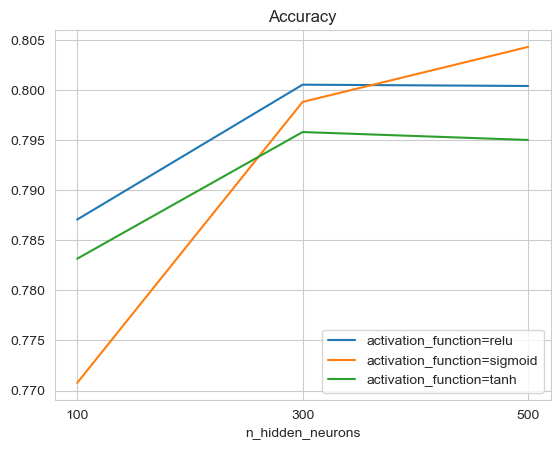

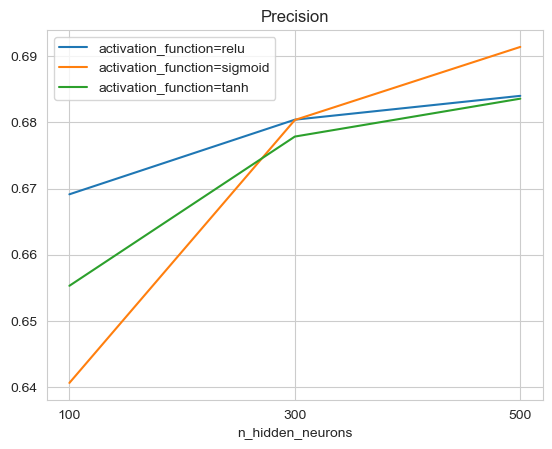

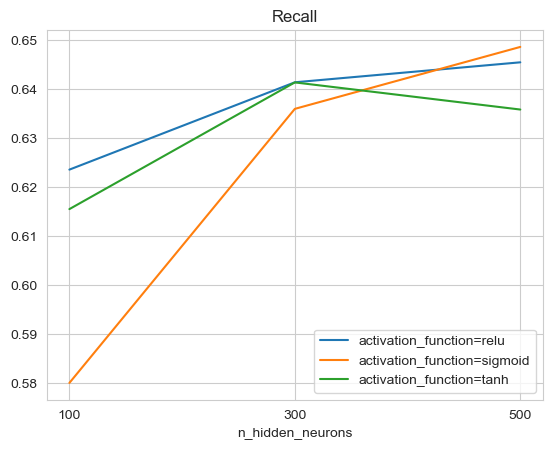

In [38]:
grid_accuracy_NN = []
grid_precision_NN = []
grid_recall_NN = []

# Append the metrics to the lists from the cv_results
for i in range(len(param_grid_NN['activation_function'])):
    temp1 = []
    temp2 = []
    temp3 = []
    for j in range(len(cv_results_NN['params'])):
        if param_grid_NN['activation_function'][i] == cv_results_NN['params'][j]['activation_function']:
            temp1.append(cv_results_NN['mean_test_accuracy'][j])
            temp2.append(cv_results_NN['mean_test_precision_macro'][j])
            temp3.append(cv_results_NN['mean_test_recall_macro'][j])
    grid_accuracy_NN.append(temp1)
    grid_precision_NN.append(temp2)
    grid_recall_NN.append(temp3)

for i in range(len(param_grid_NN['activation_function'])):
    plt.plot(range(len(param_grid_NN['n_hidden_neurons'])), grid_accuracy_NN[i],
             label=("activation_function={}".format(param_grid_NN['activation_function'][i])))
plt.legend()
plt.title("Accuracy")
plt.xticks(range(len(param_grid_NN['n_hidden_neurons'])), param_grid_NN['n_hidden_neurons'])
plt.xlabel("n_hidden_neurons")
plt.show()

for i in range(len(param_grid_NN['activation_function'])):
    plt.plot(range(len(param_grid_NN['n_hidden_neurons'])), grid_precision_NN[i],
             label=("activation_function={}".format(param_grid_NN['activation_function'][i])))
plt.legend()
plt.title("Precision")
plt.xticks(range(len(param_grid_NN['n_hidden_neurons'])), param_grid_NN['n_hidden_neurons'])
plt.xlabel("n_hidden_neurons")
plt.show()

for i in range(len(param_grid_NN['activation_function'])):
    plt.plot(range(len(param_grid_NN['n_hidden_neurons'])), grid_recall_NN[i],
             label=("activation_function={}".format(param_grid_NN['activation_function'][i])))
plt.legend()
plt.title("Recall")
plt.xticks(range(len(param_grid_NN['n_hidden_neurons'])), param_grid_NN['n_hidden_neurons'])
plt.xlabel("n_hidden_neurons")
plt.show()

### 4.3 ResNet-18

Grid search for MLP hyperparameter tuning.

In [39]:
# The residual block
def residual_block(inputs, out_channel, activation_fn, same_shape=False):
    """
    The residual block in ResNet-18.

    :param inputs: input tensor to the residual block
    :param out_channel: number of output channels/filters for the convolutional layers in the block
    :param activation_fn: activation function to be applied after each convolutional layer
    :param same_shape: a boolean flag indicating whether the input and output tensors should have the same shape
                       If False, the input tensor will be downsampled by a factor of 2
    :return: output tensor of the residual block
    """
    strides = (2, 2) if same_shape else (1, 1)

    # Convolution layers
    x = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(3, 3), strides=strides, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=activation_fn)(x)
    x = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Downsample the input if needed
    if same_shape:
        inputs = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(1, 1), strides=(2, 2), padding="same")(inputs)

    # Add the residual connection
    x = tf.keras.layers.Add()([x, inputs])
    x = tf.keras.layers.Activation(activation=activation_fn)(x)

    return x


# ResNet 18
def ResNet(activation_fn='relu'):
    """
    ResNet-18 Model.

    :param activation_fn: activation function to be applied after each convolutional layer
    :return: ResNet-18 model
    """
    inputs = tf.keras.Input(shape=(28, 28, 1))

    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=activation_fn)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

    # Residual blocks
    x = residual_block(inputs=x, out_channel=64, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=64, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=128, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=128, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=256, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=256, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=512, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=512, activation_fn=activation_fn)

    # Global average pooling and dense layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=62, activation="softmax")(x)

    # Create and return the ResNet-18 model
    res_net = tf.keras.Model(inputs=inputs, outputs=x)

    return res_net


# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier_CNN = KerasClassifier(model=ResNet, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                                       loss="categorical_crossentropy", batch_size=64,
                                       metrics=['accuracy', 'Precision', 'Recall'], epochs=10, shuffle=True,
                                       validation_split=0.2, activation_fn='relu')

In [41]:
# grid-search with cross-validation for parameter tuning
param_grid_CNN = {"batch_size": [32, 64, 128], "activation_fn": ["relu", "sigmoid", "tanh"]}

grid_search_CNN = GridSearchCV(estimator=keras_classifier_CNN, param_grid=param_grid_CNN, cv=2, return_train_score=True,
                               scoring=['accuracy', 'precision_macro', 'recall_macro'], refit='accuracy')
grid_search_CNN.fit(X=X_train_img_norm, y=y_train_one)

Epoch 1/10
1250/1250 [==============================] - 164s 131ms/step - loss: 0.9405 - accuracy: 0.7139 - precision_19: 0.7872 - recall_19: 0.6525 - val_loss: 0.7176 - val_accuracy: 0.7657 - val_precision_19: 0.8059 - val_recall_19: 0.7271
Epoch 2/10
1250/1250 [==============================] - 164s 131ms/step - loss: 0.6047 - accuracy: 0.7934 - precision_19: 0.8328 - recall_19: 0.7546 - val_loss: 0.6197 - val_accuracy: 0.7884 - val_precision_19: 0.8314 - val_recall_19: 0.7502
Epoch 3/10
1250/1250 [==============================] - 166s 133ms/step - loss: 0.5236 - accuracy: 0.8187 - precision_19: 0.8505 - recall_19: 0.7839 - val_loss: 0.6029 - val_accuracy: 0.8008 - val_precision_19: 0.8363 - val_recall_19: 0.7683
Epoch 4/10
1250/1250 [==============================] - 165s 132ms/step - loss: 0.4865 - accuracy: 0.8274 - precision_19: 0.8580 - recall_19: 0.7965 - val_loss: 0.6110 - val_accuracy: 0.8010 - val_precision_19: 0.8286 - val_recall_19: 0.7784
Epoch 5/10
1250/1250 [==========

Epoch 6/10
1250/1250 [==============================] - 160s 128ms/step - loss: 0.5432 - accuracy: 0.8106 - precision_25: 0.8433 - recall_25: 0.7779 - val_loss: 5.1040 - val_accuracy: 0.1751 - val_precision_25: 0.1776 - val_recall_25: 0.0941
Epoch 7/10
1250/1250 [==============================] - 160s 128ms/step - loss: 0.5242 - accuracy: 0.8169 - precision_25: 0.8469 - recall_25: 0.7871 - val_loss: 5.0287 - val_accuracy: 0.1859 - val_precision_25: 0.2904 - val_recall_25: 0.1447
Epoch 8/10
1250/1250 [==============================] - 161s 129ms/step - loss: 0.5055 - accuracy: 0.8230 - precision_25: 0.8514 - recall_25: 0.7947 - val_loss: 8.9671 - val_accuracy: 0.0282 - val_precision_25: 0.0399 - val_recall_25: 0.0232
Epoch 9/10
1250/1250 [==============================] - 162s 129ms/step - loss: 0.4898 - accuracy: 0.8243 - precision_25: 0.8524 - recall_25: 0.7976 - val_loss: 6.4599 - val_accuracy: 0.1413 - val_precision_25: 0.1737 - val_recall_25: 0.1290
Epoch 10/10
1563/1563 [=========

1563/1563 [==============================] - 24s 15ms/step
Epoch 1/10
1250/1250 [==============================] - 160s 128ms/step - loss: 1.0741 - accuracy: 0.6744 - precision_32: 0.7630 - recall_32: 0.6010 - val_loss: 0.7824 - val_accuracy: 0.7439 - val_precision_32: 0.8041 - val_recall_32: 0.6820
Epoch 2/10
1250/1250 [==============================] - 159s 128ms/step - loss: 0.6759 - accuracy: 0.7770 - precision_32: 0.8178 - recall_32: 0.7362 - val_loss: 0.8920 - val_accuracy: 0.7155 - val_precision_32: 0.7617 - val_recall_32: 0.6733
Epoch 3/10
1250/1250 [==============================] - 160s 128ms/step - loss: 0.5931 - accuracy: 0.7958 - precision_32: 0.8300 - recall_32: 0.7621 - val_loss: 0.5793 - val_accuracy: 0.8063 - val_precision_32: 0.8299 - val_recall_32: 0.7910
Epoch 4/10
1250/1250 [==============================] - 159s 128ms/step - loss: 0.5451 - accuracy: 0.8085 - precision_32: 0.8382 - recall_32: 0.7801 - val_loss: 0.5992 - val_accuracy: 0.7848 - val_precision_32: 0.82

GridSearchCV(cv=2,
             estimator=KerasClassifier(activation_fn='relu', batch_size=64, epochs=10, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'], model=<function ResNet at 0x157b42430>, optimizer=<keras.optimizers.legacy.adam.Adam object at 0x32b285910>, validation_split=0.2),
             param_grid={'activation_fn': ['relu', 'sigmoid', 'tanh'],
                         'batch_size': [32, 64, 128]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision_macro', 'recall_macro'])

In [42]:
print("Best parameters: {}".format(grid_search_CNN.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search_CNN.best_score_)) 
print("Best estimator: {}".format(grid_search_CNN.best_estimator_))
print("Test set score: {:.4f}".format(grid_search_CNN.score(X_test_img_norm, y_test_one))) 

Best parameters: {'activation_fn': 'relu', 'batch_size': 64}
Best cross-validation score: 0.84
Best estimator: KerasClassifier(
	model=<function ResNet at 0x157b42430>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=<keras.optimizers.legacy.adam.Adam object at 0x319407bb0>
	loss=categorical_crossentropy
	metrics=['accuracy', 'Precision', 'Recall']
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=10
	activation_fn=relu
	class_weight=None
)
313/313 [==============================] - 6s 19ms/step
Test set score: 0.8535


Visualize the performance of different Hyperparameters.

In [43]:
cv_results_CNN = grid_search_CNN.cv_results_

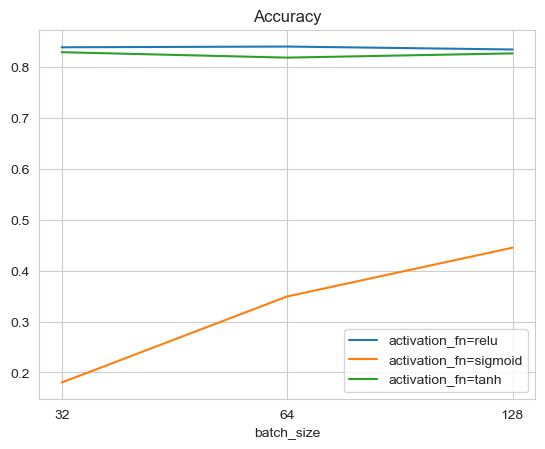

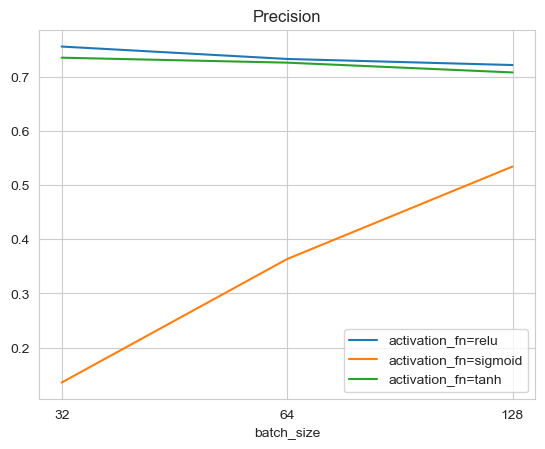

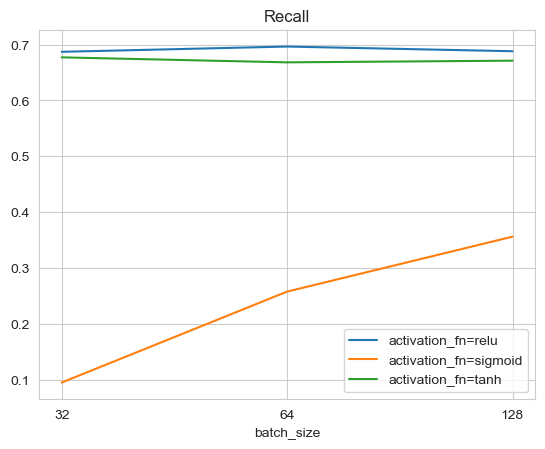

In [44]:
grid_accuracy_CNN = []
grid_precision_CNN = []
grid_recall_CNN = []

# Append the metrics to the lists from the cv_results
for i in range(len(param_grid_CNN['activation_fn'])):
    temp1 = []
    temp2 = []
    temp3 = []
    for j in range(len(cv_results_CNN['params'])):
        if param_grid_CNN['activation_fn'][i] == cv_results_CNN['params'][j]['activation_fn']:
            temp1.append(cv_results_CNN['mean_test_accuracy'][j])
            temp2.append(cv_results_CNN['mean_test_precision_macro'][j])
            temp3.append(cv_results_CNN['mean_test_recall_macro'][j])
    grid_accuracy_CNN.append(temp1)
    grid_precision_CNN.append(temp2)
    grid_recall_CNN.append(temp3)

for i in range(len(param_grid_CNN['activation_fn'])):
    plt.plot(range(len(param_grid_CNN['batch_size'])), grid_accuracy_CNN[i],
             label=("activation_fn={}".format(param_grid_CNN['activation_fn'][i])))
plt.legend()
plt.title("Accuracy")
plt.xticks(range(len(param_grid_CNN['batch_size'])), param_grid_CNN['batch_size'])
plt.xlabel("batch_size")
plt.show()

for i in range(len(param_grid_CNN['activation_fn'])):
    plt.plot(range(len(param_grid_CNN['batch_size'])), grid_precision_CNN[i],
             label=("activation_fn={}".format(param_grid_CNN['activation_fn'][i])))
plt.legend()
plt.title("Precision")
plt.xticks(range(len(param_grid_CNN['batch_size'])), param_grid_CNN['batch_size'])
plt.xlabel("batch_size")
plt.show()

for i in range(len(param_grid_CNN['activation_fn'])):
    plt.plot(range(len(param_grid_CNN['batch_size'])), grid_recall_CNN[i],
             label=("activation_fn={}".format(param_grid_CNN['activation_fn'][i])))
plt.legend()
plt.title("Recall")
plt.xticks(range(len(param_grid_CNN['batch_size'])), param_grid_CNN['batch_size'])
plt.xlabel("batch_size")
plt.show()

## 5. Final Models & Model Evaluation

### 5.1 Best KNN

In [45]:
# Final model for kNN
best_knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
best_knn.fit(X=X_train_pca, y=y_train)

KNeighborsClassifier(weights='distance')

In [46]:
best_knn_accuracy = best_knn.score(X=X_test_pca, y=y_test)

best_knn_pred = best_knn.predict(X=X_test_pca)

best_knn_precision = precision_score(y_true=y_test, y_pred=best_knn_pred, average='macro')
best_knn_recall = recall_score(y_true=y_test, y_pred=best_knn_pred, average='macro')
best_knn_cm = confusion_matrix(y_true=y_test, y_pred=best_knn_pred)

print("Accuracy on test set: {:.3f}%".format(100 * best_knn_accuracy))
print("Precision on test set: {:.3f}%".format(100 * best_knn_precision))
print("Recall on test set: {:.3f}%".format(100 * best_knn_recall))
print("Confusion_matrix: \n", best_knn_cm)

Accuracy on test set: 69.580%
Precision on test set: 60.505%
Recall on test set: 48.875%
Confusion_matrix: 
 [[641   4   0 ...   0   0   0]
 [  0 842   2 ...   0   0   0]
 [ 29  14 833 ...   0   1   9]
 ...
 [  0  14   2 ...  46   3   0]
 [  0  10   0 ...   1   6   0]
 [  0   1  34 ...   0   0  25]]


In [47]:
print(classification_report(y_true=y_test, y_pred=best_knn_pred))

              precision    recall  f1-score   support

           0       0.54      0.66      0.59       976
           1       0.45      0.82      0.58      1023
           2       0.88      0.83      0.85      1003
           3       0.86      0.92      0.89      1035
           4       0.88      0.79      0.83       903
           5       0.84      0.74      0.79       928
           6       0.88      0.93      0.91       959
           7       0.85      0.93      0.89      1098
           8       0.96      0.76      0.85       941
           9       0.85      0.92      0.88       929
          10       0.78      0.53      0.63       170
          11       0.75      0.05      0.10       118
          12       0.58      0.79      0.67       316
          13       0.82      0.29      0.43       128
          14       0.89      0.36      0.52       162
          15       0.69      0.49      0.57       261
          16       0.87      0.33      0.48        60
          17       0.71    

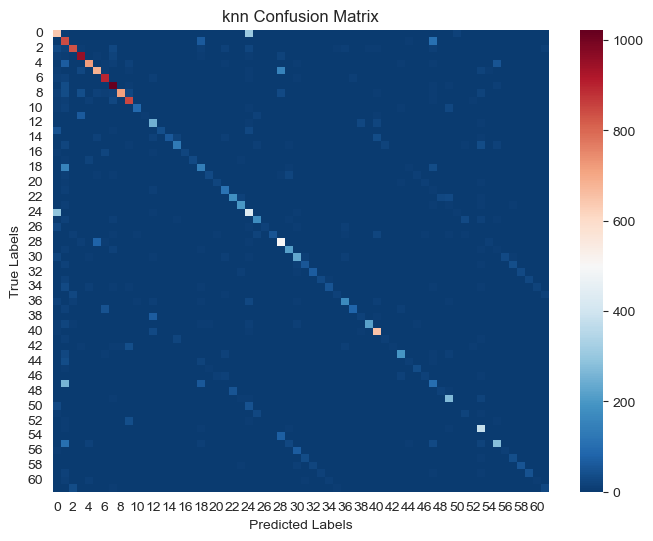

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=best_knn_cm, fmt="d", cmap="RdBu_r", center=500)
plt.title("knn Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### 5.2 Best MLP

In [49]:
# Model Initialisation
best_NN = keras.Sequential()
# Input layer
best_NN.add(keras.layers.Flatten(input_shape=[X_train_norm.shape[1]]))
# Hidden Layer 1
best_NN.add(keras.layers.Dense(units=500, activation='sigmoid'))
# Hidden Layer 2
best_NN.add(keras.layers.Dense(units=500, activation='sigmoid'))
# Output Layer
best_NN.add(keras.layers.Dense(units=62, activation='softmax'))

In [50]:
best_NN.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 dense_80 (Dense)            (None, 500)               392500    
                                                                 
 dense_81 (Dense)            (None, 500)               250500    
                                                                 
 dense_82 (Dense)            (None, 62)                31062     
                                                                 
Total params: 674,062
Trainable params: 674,062
Non-trainable params: 0
_________________________________________________________________


In [51]:
# Instantiate optimiser and compile the model.
best_NN.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                metrics=['accuracy', 'Precision', 'Recall'])

# Train the classifier
best_NN_results = best_NN.fit(x=X_train_norm, y=y_train_one, epochs=10, batch_size=64, shuffle=True,
                              validation_split=0.2)

Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3236 - accuracy: 0.6380 - precision: 0.8177 - recall: 0.4867 - val_loss: 0.8702 - val_accuracy: 0.7308 - val_precision: 0.8296 - val_recall: 0.6336
Epoch 2/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7485 - accuracy: 0.7650 - precision: 0.8384 - recall: 0.6917 - val_loss: 0.6806 - val_accuracy: 0.7893 - val_precision: 0.8459 - val_recall: 0.7352
Epoch 3/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6148 - accuracy: 0.7975 - precision: 0.8499 - recall: 0.7434 - val_loss: 0.6038 - val_accuracy: 0.8075 - val_precision: 0.8599 - val_recall: 0.7594
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5417 - accuracy: 0.8155 - precision: 0.8583 - recall: 0.7714 - val_loss: 0.5685 - val_accuracy: 0.8129 - val_precision: 0.8573 - val_recall: 0.7722
Epoch 5/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4926 - accuracy: 0

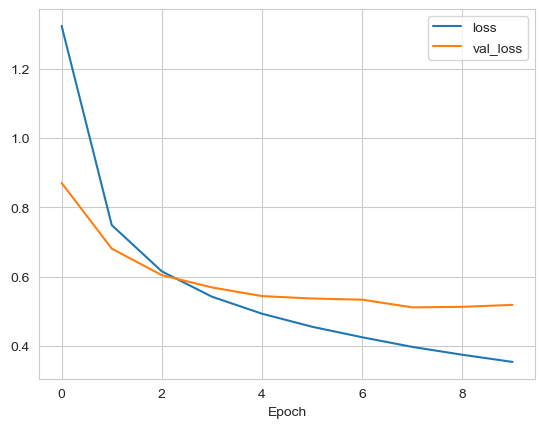

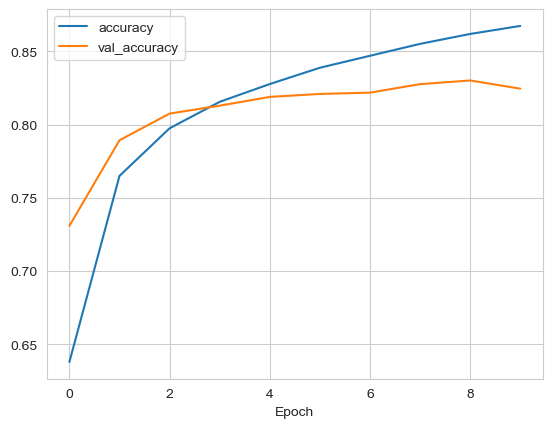

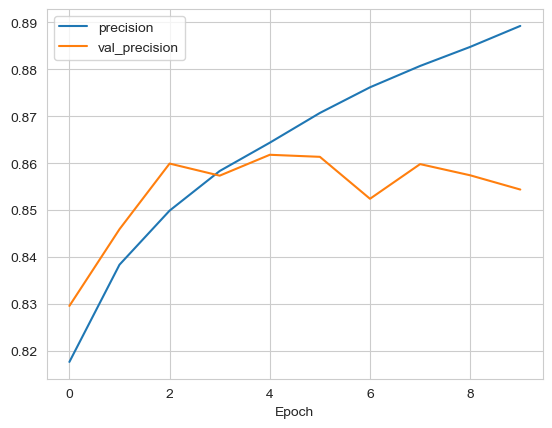

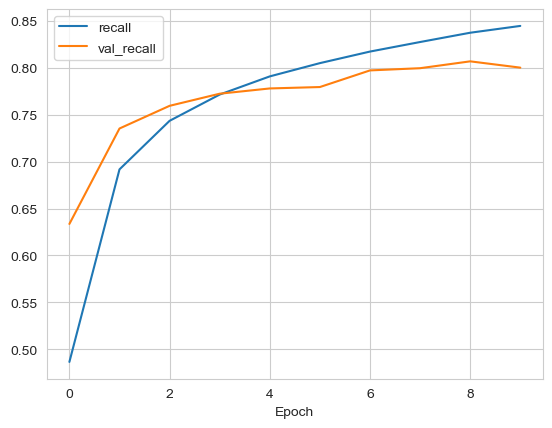

In [52]:
# Convert the history result dictionary to a Pandas dataframe and extract the accuracies
best_NN_loss = pd.DataFrame(best_NN_results.history)[['loss', 'val_loss']]
best_NN_accuracy = pd.DataFrame(best_NN_results.history)[['accuracy', 'val_accuracy']]
best_NN_precision = pd.DataFrame(best_NN_results.history)[['precision', 'val_precision']]
best_NN_recall = pd.DataFrame(best_NN_results.history)[['recall', 'val_recall']]

# Plot
best_NN_loss.plot()
plt.xlabel('Epoch')
plt.show()

best_NN_accuracy.plot()
plt.xlabel('Epoch')
plt.show()

best_NN_precision.plot()
plt.xlabel('Epoch')
plt.show()

best_NN_recall.plot()
plt.xlabel('Epoch')
plt.show()

In [53]:
best_NN_loss_test, best_NN_accuracy_test, best_NN_precision_test, best_NN_recall_test = model_NN.evaluate(x=X_test_norm,
                                                                                                          y=y_test_one)

best_NN_pred = best_NN.predict(x=X_test_norm)
best_NN_cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(best_NN_pred, axis=1))

print("Loss on test set: {:.4f}".format(best_NN_loss_test))
print("Accuracy on test set: {:.4f}%".format(100 * best_NN_accuracy_test))
print("Precision on test set: {:.4f}%".format(100 * best_NN_precision_test))
print("Recall on test set: {:.4f}%".format(100 * best_NN_recall_test))
print("Confusion_matrix: \n", best_NN_cm)

625/625 [==============================] - 0s 747us/step
Loss on test set: 0.5870
Accuracy on test set: 80.6650%
Precision on test set: 83.1636%
Recall on test set: 78.3900%
Confusion_matrix: 
 [[860   0   1 ...   0   0   0]
 [  0 930   2 ...   0   0   0]
 [  2   0 973 ...   0   0   4]
 ...
 [  0   1   0 ...  59   0   1]
 [  0   0   0 ...   1   8   0]
 [  0   0  28 ...   2   0  31]]


In [54]:
print(classification_report(y_true=y_test, y_pred=np.argmax(best_NN_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.62      0.88      0.73       976
           1       0.67      0.91      0.77      1023
           2       0.91      0.97      0.94      1003
           3       0.97      0.97      0.97      1035
           4       0.94      0.96      0.95       903
           5       0.81      0.95      0.87       928
           6       0.93      0.97      0.95       959
           7       0.98      0.96      0.97      1098
           8       0.92      0.96      0.94       941
           9       0.91      0.96      0.93       929
          10       0.91      0.86      0.88       170
          11       0.82      0.76      0.79       118
          12       0.74      0.73      0.74       316
          13       0.84      0.80      0.82       128
          14       0.92      0.86      0.89       162
          15       0.85      0.74      0.79       261
          16       0.73      0.80      0.76        60
          17       0.83    

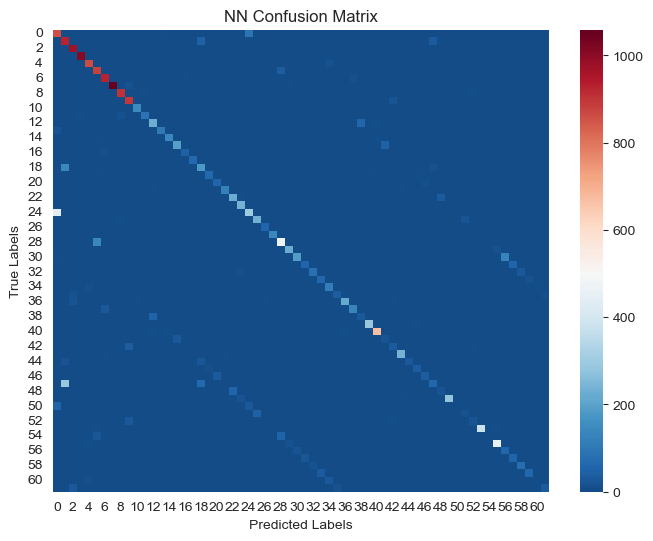

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=best_NN_cm, fmt="d", cmap="RdBu_r", center=500)
plt.title("NN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### 5.3 Best ResNet-18

In [56]:
# The residual block
def residual_block(inputs, out_channel, activation_fn, same_shape=False):
    """
    The residual block in ResNet-18.

    :param inputs: input tensor to the residual block
    :param out_channel: number of output channels/filters for the convolutional layers in the block
    :param activation_fn: activation function to be applied after each convolutional layer
    :param same_shape: a boolean flag indicating whether the input and output tensors should have the same shape
                       If False, the input tensor will be downsampled by a factor of 2
    :return: output tensor of the residual block
    """
    strides = (2, 2) if same_shape else (1, 1)

    # Convolution layers
    x = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(3, 3), strides=strides, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=activation_fn)(x)

    x = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Downsample the input if needed
    if same_shape:
        inputs = tf.keras.layers.Conv2D(filters=out_channel, kernel_size=(1, 1), strides=(2, 2), padding="same")(inputs)

    # Add the residual connection
    x = tf.keras.layers.Add()([x, inputs])
    x = tf.keras.layers.Activation(activation=activation_fn)(x)

    return x


# ResNet 18
def ResNet(activation_fn):
    """
    ResNet-18 Model.

    :param activation_fn: activation function to be applied after each convolutional layer
    :return: ResNet-18 model
    """
    inputs = tf.keras.Input(shape=(28, 28, 1))

    # Initial convolutional layer
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation=activation_fn)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(x)

    # Residual blocks
    x = residual_block(inputs=x, out_channel=64, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=64, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=128, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=128, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=256, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=256, activation_fn=activation_fn)
    x = residual_block(inputs=x, out_channel=512, activation_fn=activation_fn, same_shape=True)
    x = residual_block(inputs=x, out_channel=512, activation_fn=activation_fn)

    # Global average pooling and dense layer
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=62, activation="softmax")(x)

    # Create and return the ResNet-18 model
    res_net = tf.keras.Model(inputs=inputs, outputs=x)

    return res_net


# Initialize
best_CNN = ResNet(activation_fn='relu')

In [57]:
best_CNN.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_400 (Conv2D)            (None, 14, 14, 64)   3200        ['input_21[0][0]']               
                                                                                                  
 batch_normalization_340 (Batch  (None, 14, 14, 64)  256         ['conv2d_400[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_340 (Activation)    (None, 14, 14, 64)   0           ['batch_normalization_340[

 activation_348 (Activation)    (None, 4, 4, 128)    0           ['add_163[0][0]']                
                                                                                                  
 conv2d_410 (Conv2D)            (None, 2, 2, 256)    295168      ['activation_348[0][0]']         
                                                                                                  
 batch_normalization_349 (Batch  (None, 2, 2, 256)   1024        ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_349 (Activation)    (None, 2, 2, 256)    0           ['batch_normalization_349[0][0]']
                                                                                                  
 conv2d_411 (Conv2D)            (None, 2, 2, 256)    590080      ['activation_349[0][0]']         
          

In [58]:
best_CNN.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss="categorical_crossentropy",
                 metrics=['accuracy', 'Precision', 'Recall'])
best_CNN_results = best_CNN.fit(x=X_train_img_norm, y=y_train_one, batch_size=64, epochs=10, validation_split=0.2,
                                shuffle=True)

Epoch 1/10
1250/1250 [==============================] - 298s 238ms/step - loss: 0.7356 - accuracy: 0.7632 - precision: 0.8179 - recall: 0.7149 - val_loss: 0.7446 - val_accuracy: 0.7620 - val_precision: 0.8106 - val_recall: 0.7185
Epoch 2/10
1250/1250 [==============================] - 293s 234ms/step - loss: 0.4982 - accuracy: 0.8234 - precision: 0.8543 - recall: 0.7924 - val_loss: 0.8409 - val_accuracy: 0.7283 - val_precision: 0.7872 - val_recall: 0.6722
Epoch 3/10
1250/1250 [==============================] - 289s 232ms/step - loss: 0.4515 - accuracy: 0.8366 - precision: 0.8626 - recall: 0.8086 - val_loss: 0.4793 - val_accuracy: 0.8384 - val_precision: 0.8647 - val_recall: 0.8127
Epoch 4/10
1250/1250 [==============================] - 285s 228ms/step - loss: 0.4197 - accuracy: 0.8455 - precision: 0.8694 - recall: 0.8212 - val_loss: 0.4542 - val_accuracy: 0.8433 - val_precision: 0.8710 - val_recall: 0.8186
Epoch 5/10
1250/1250 [==============================] - 289s 231ms/step - loss: 

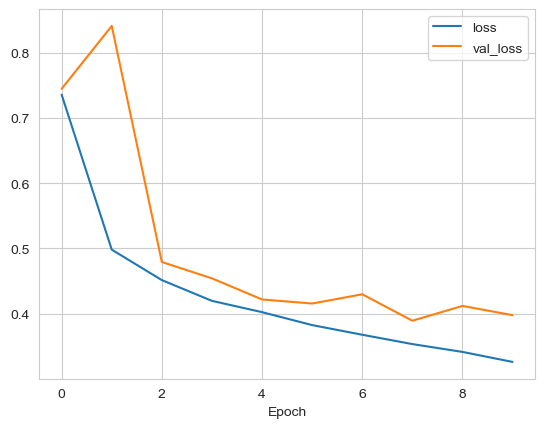

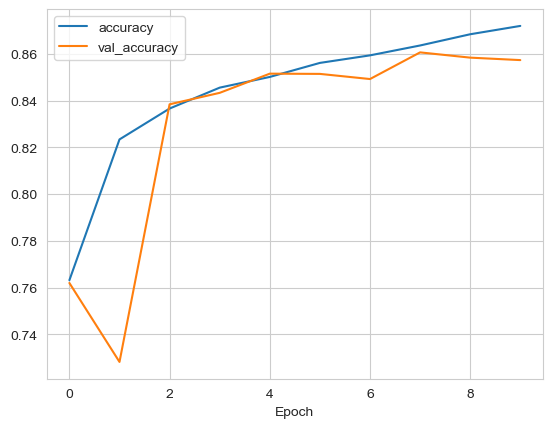

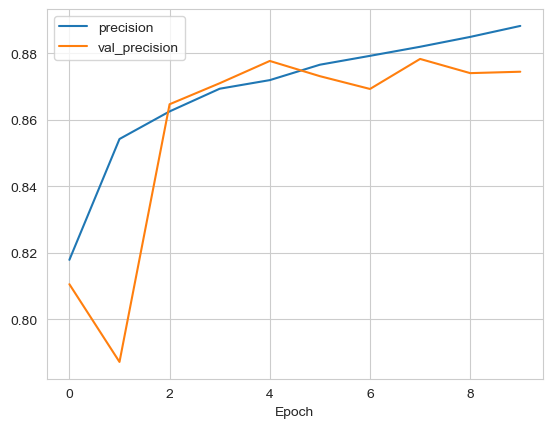

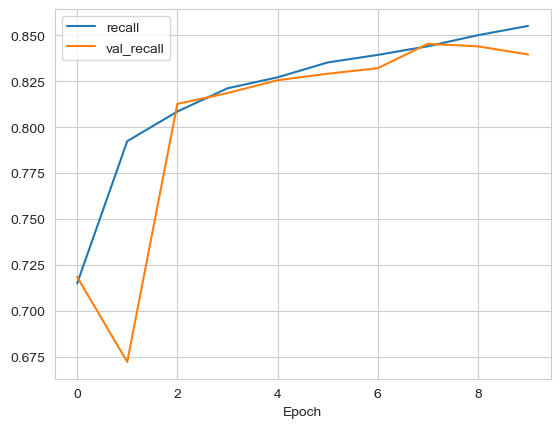

In [59]:
# Convert the history result dictionary to a Pandas dataframe and extract the accuracies
best_CNN_loss = pd.DataFrame(best_CNN_results.history)[['loss', 'val_loss']]
best_CNN_accuracy = pd.DataFrame(best_CNN_results.history)[['accuracy', 'val_accuracy']]
best_CNN_precision = pd.DataFrame(best_CNN_results.history)[['precision', 'val_precision']]
best_CNN_recall = pd.DataFrame(best_CNN_results.history)[['recall', 'val_recall']]

# Plot
best_CNN_loss.plot()
plt.xlabel('Epoch')
plt.show()

best_CNN_accuracy.plot()
plt.xlabel('Epoch')
plt.show()

best_CNN_precision.plot()
plt.xlabel('Epoch')
plt.show()

best_CNN_recall.plot()
plt.xlabel('Epoch')
plt.show()

In [60]:
best_CNN_loss_test, best_CNN_accuracy_test, best_CNN_precision_test, best_CNN_recall_test = model_CNN.evaluate(
    x=X_test_img_norm, y=y_test_one)

best_CNN_pred = model_CNN.predict(x=X_test_img_norm)
best_CNN_cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(best_CNN_pred, axis=1))

print("Loss on test set: {:.4f}".format(best_CNN_loss_test))
print("Accuracy on test set: {:.4f}%".format(100 * best_CNN_accuracy_test))
print("Precision on test set: {:.4f}%".format(100 * best_CNN_precision_test))
print("Recall on test set: {:.4f}%".format(100 * best_CNN_recall_test))
print("Confusion_matrix: \n", best_CNN_cm)

625/625 [==============================] - 8s 13ms/step
Loss on test set: 0.4238
Accuracy on test set: 85.0800%
Precision on test set: 87.0469%
Recall on test set: 83.0950%
Confusion_matrix: 
 [[827   0   1 ...   0   0   0]
 [  0 964   1 ...   0   0   0]
 [  0   0 983 ...   1   0   4]
 ...
 [  0   0   0 ...  87   1   0]
 [  0   0   0 ...   0  15   0]
 [  0   0  16 ...   2   0  46]]


In [63]:
print(classification_report(y_true=y_test, y_pred=np.argmax(best_CNN_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       976
           1       0.66      0.94      0.78      1023
           2       0.95      0.98      0.96      1003
           3       1.00      0.99      0.99      1035
           4       0.97      0.95      0.96       903
           5       0.90      0.95      0.92       928
           6       0.96      0.97      0.97       959
           7       0.95      0.99      0.97      1098
           8       0.97      0.96      0.97       941
           9       0.92      0.97      0.94       929
          10       0.95      0.95      0.95       170
          11       0.92      0.86      0.89       118
          12       0.70      0.98      0.82       316
          13       0.93      0.88      0.90       128
          14       0.97      0.93      0.95       162
          15       0.82      0.93      0.87       261
          16       0.89      0.85      0.87        60
          17       0.85    

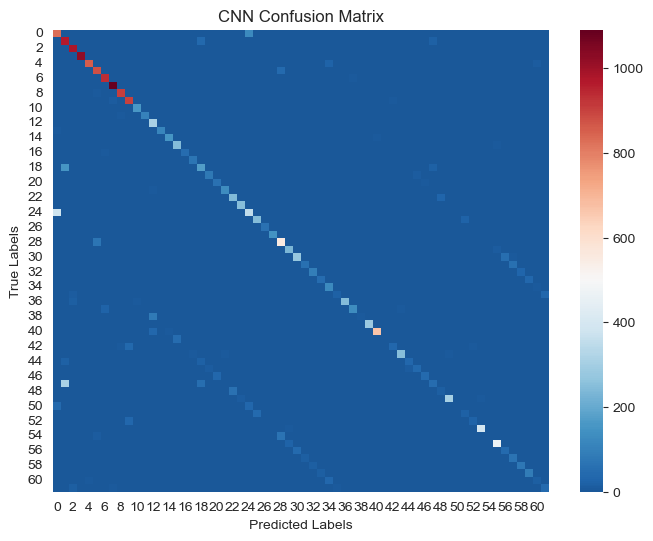

In [64]:
plt.figure(figsize=(8, 6))
sns.heatmap(data=best_CNN_cm, fmt="d", cmap="RdBu_r", center=500)
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()